#Loading dataset

For this lesson, we'll be working with the [Student Performance Dataset](https://archive.ics.uci.edu/dataset/320/student+performance), which is available from the UCI Machine Learning Repository site.

In order to improve the quality and pacing of the exercises, we'll be using a truncated version of the dataset, but after finishing the lesson, if you want to use the remaining columns for further analysis, you're welcome to do so!


Now, regarding the dataset content, it measures student qualifications in the Portuguese language in two secondary schools. Let's explore the descriptions for the columns we chose for the lesson:

`absences:` number of school absences (numeric: from 0 to 93)

`health:` current health status (ordinal: ["Very Bad", "Bad", "Regular", "Good", "Very Good"])

`sex:` student's sex (binary: 'F' — female, or 'M' — male)

`internet`: internet access at home (binary: "yes" or "no")

`Mjob:` mother's job (categorical: "teacher," "health" care-related, civil "services" (e.g., administrative or police), "at_home," or "other")

`Fjob:` father's job (categorical: "teacher," "health" care-related, civil "services" (e.g., administrative or police), "at_home," or "other")

`guardian:` student's guardian (categorical: "mother," "father," or "other")

`Pstatus:` parent's cohabitation status (binary: "T" — living together or "A" — apart)

`famrel:` quality of family relationships (ordinal: "Very Bad," "Bad," "Regular," "Good," or "Excellent")

`G3:` final grade (numeric: from 0 to 20, output target)

To summarize, the dataset includes demographic, social, and school-related aspects as feature columns. We will perform some transformations on these so they become suitable to train our decision trees.

As for the the **target column G3**, due to it including continuous data, it's ready for use in a regression tree, but we will also explore how to transform its observations to categories in order to train a classification tree as well.

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/student-por.csv",
                  usecols = ["famrel", "Mjob", "Fjob",
                             "guardian", "Pstatus", "sex",
                             "internet", "health", "absences",
                             "G3"],
                  sep = ";")

df = df[["absences", "health", "sex", "internet", "Mjob", "Fjob", "guardian", "Pstatus", "famrel", "G3"]]

print(df.head(5))

   absences     health sex internet     Mjob      Fjob guardian Pstatus  \
0         4    Regular   F       no  at_home   teacher   mother       A   
1         2    Regular   F      yes  at_home     other   father       T   
2         6    Regular   F      yes  at_home     other   mother       T   
3         0  Very Good   F      yes   health  services   mother       T   
4         0  Very Good   F       no    other     other   father       T   

      famrel  G3  
0       Good  11  
1  Excellent  11  
2       Good  12  
3    Regular  14  
4       Good  13  


# Ordinal Encoding

The first type of preprocessing we'll perform is called ordinal encoding. Here's the definition of ordinal data: categorical columns whose labels have some kind of hierarchy or ranking (i.e., minor|moderate|serious|fatal). In this sense, the column health meets this condition because its unique values are: "`Very Bad`", "`Bad`", "`Regular`", "`Good`", and "`Very Good`", and we can apply ordinal encoding to them so that they become an ordered sequence of numbers, such as: `[0, 1, 2, 3, 4]`. Under these numerical values, "Very Bad" becomes `0`, "`Bad`" becomes `1`, and so on.

We will learn two methods for accomplishing this. The first method is to manually replace the values using .loc, using the following syntax for each unique value:

    df.loc[df["health"] == "Very Bad", "health"] = 0

    df.loc[df["health"] == "Bad", "health"] = 1

 . . and so on.

 The second method is by using `scikit-learn`. Not only does it have machine learning models, it also includes plenty of preprocessing tools like `OrdinalEncoder()`. Using the `categories` parameter, we pass a list in double brackets with the ordered values of the column. As with the previous method, it will replace every label with a number: "`Very Bad`" with `0`, "`Bad`" with `1`, etc.

 from sklearn.preprocessing import OrdinalEncoder

    ordinal_health = [["Very Bad", "Bad", "Regular", "Good", "Very Good"]]

    df["health"] = OrdinalEncoder(categories = ordinal_health).fit_transform(df[["health"]])

When using `OrdinalEncoder()`, we should always configure the categories parameter, otherwise scikit-learn will assign the numbers to the categories based on the order in which they appear in the observations. So, for instance, if your first two observations include the categories "`Regular`" and "`Very Good`", it will treat them as 0, 1 respectively, which would create an incorrect hierarchy.

Finally, the `fit_transform()` method trains ("fits") the encoder by using the column's data as input and then automatically transforms the column with the processed information.

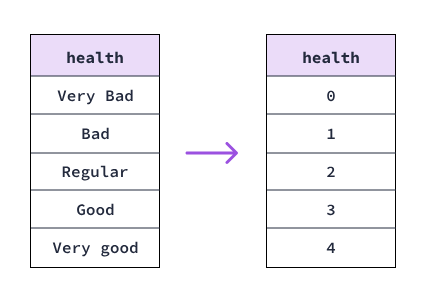

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_famrel = [["Very Bad", "Bad", "Regular", "Good", "Excellent"]]

df.loc[df["health"] == "Very Bad", "health"] = 0
df.loc[df["health"] == "Bad", "health"] = 1
df.loc[df["health"] == "Regular", "health"] = 2
df.loc[df["health"] == "Good", "health"] = 3
df.loc[df["health"] == "Very Good", "health"] = 4


df[['famrel']] = OrdinalEncoder(categories = ordinal_famrel).fit_transform(df[["famrel"]])

#  Categorical Encoding with Pandas

We can extend the logic to other binary columns, like the sex column, in our dataset. Since we only have `F` ("female") and `M` ("male") values, one of them can be considered 0 and the other 1.

    df["sex"].replace({"M": 0, "F": 1}, inplace = True)

And to avoid confusion, we rename the column. For example, since `F` was replaced with 1 ("True"), then we can rename the column to `sex_fem`, so when we see a 0 ("False") we know its value is `M` ("male").

    df.rename(columns = {"sex": "sex_fem"}, inplace = True)


## Categorical Data with More Than Two Unique Values

we assign increasing numeric values to the unique values within a categorical column with ordinal data in order to mimic its underlying hierarchy. To deal with categorical columns that **don't have a hierarchy**, there are a couple of different approaches we can take. While the steps may differ between the approaches, the strategy remains the same: **we create a new column for each unique category and populate it with a `1` if the observation is in that category and `0` if it isn't.**

For example, if we have a categorical column traffic_light, with three unique categories ("`red`", "`yellow`", and "`green`"), we split the column into **three columns:** `traffic_red`, `traffic_yellow`, and `traffic_green`. If an observation is categorized as green in the `traffic_light` column, it will have a `1` in the newly created `traffic_green` column and a `0` in both the traffic_red and traffic_yellow columns.

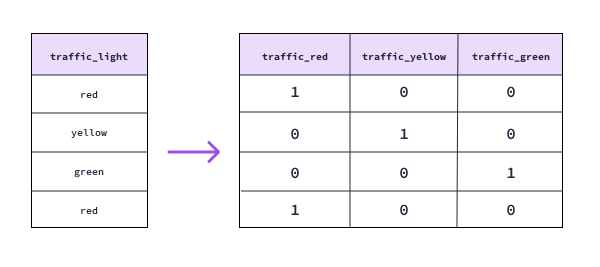

##Creating categorical columns with dummies

Let's explore the first approach using pandas.get_dummies(), and apply it on the guardian column, which has three possible values: "`mother`", "`father`", and "`other`".

1) Create a new DataFrame with the dummy columns:

    guardian_dummy = pd.get_dummies(
                df["guardian"],
                prefix = "guardian")

The `prefix` parameter adds a prefix to each resulting dummy column to quickly identify the source column. In this case, the dummy columns will be `guardian_mother`, `guardian_father`, and `guardian_other`.

If we have several columns to process, we slightly alter the syntax:

    manycols_dummies = pd.get_dummies(
                df[["column1", "column2"]],
                prefix = ["column1_prefix", "column2_prefix"])

We enclose the column names with double brackets, and we use a list of prefixes for the `prefix` parameter, which needs to match the order of columns — otherwise the prefixes will be assigned incorrectly.

2) Next, we merge these new columns with the original dataset:

    df = pd.concat([df, guardian_dummy], axis = 1)

3) Finally, we erase the original guardian column:

    df.drop("guardian", axis = 1, inplace = True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

ordinal_famrel = [["Very Bad", "Bad", "Regular", "Good", "Excellent"]]

df["famrel"] = OrdinalEncoder(categories=ordinal_famrel).fit_transform(df[["famrel"]])

# PREPROCESSING DONE ON THIS SCREEN

df["sex"].replace({"M": 0, "F": 1}, inplace=True)
df.rename(columns={"sex": "sex_fem"}, inplace=True)

guard_dummy = pd.get_dummies(df["guardian"], prefix="guardian")

df = pd.concat([df, guard_dummy], axis = 1)
df.drop("guardian", axis = 1, inplace = True)

#Transform internet in a binary number
df["internet"].replace({"no": 0, "yes": 1}, inplace = True)

#transform Pstatus in a binary number
df["Pstatus"].replace({"T": 0, "A": 1}, inplace = True)

#rename column
df.rename(columns={"Pstatus": "parents_apart"}, inplace=True)


#convert Mjob and Fjob in to dummies
dummies = pd.get_dummies(df[["Mjob", "Fjob"]],prefix=["mother","father"])
df = pd.concat([df, dummies], axis = 1)
df.drop(["Mjob","Fjob"], axis = 1, inplace = True)


ValueError: could not convert string to float: 'Very Bad'

# Categorical Encoding Using Scikit-learn

Good job using the `get_dummies`() function on the previous screen! Now let's look at the second approach that uses another scikit-learn preprocessing tool: `OneHotEncoder`.

On this screen, we'll explore two ways to implement it: first we'll use `OneHotEncoder` on its own, and second, we'll use it in combination with another scikit-learn tool: `make_column_transformer`.

##Using OneHotEncoder on Its Own



In [73]:
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/student-por.csv",
                  usecols = ["famrel", "Mjob", "Fjob",
                             "guardian", "Pstatus", "sex",
                             "internet", "health", "absences",
                             "G3"],
                  sep = ";")

df = df[["absences", "health", "sex", "internet", "Mjob", "Fjob", "guardian", "Pstatus", "famrel", "G3"]]


onehot = OneHotEncoder() # Instantiating Encoder
onehot_fit = onehot.fit(df[["guardian"]]) # Fit Encoder to target column

column_names = onehot_fit.get_feature_names_out() # Get column names
onehot_col = onehot_fit.transform(df[["guardian"]]) # Transform target column with the Encoder
onehot_col = onehot_col.toarray() # Transform the column to an array for pandas compatibility.

guardian_onehotencoded = pd.DataFrame(onehot_col, columns = column_names) # Create dataset with dummy columns
df = pd.concat([df, guardian_onehotencoded], axis = 1) # Merging dataset with the original one
df.drop("guardian", axis = 1, inplace = True) # Remove original column

##Using OneHotEncoder with make_column_transformer

We can also use `OneHotEncoder` with `make_column_transformer`, which allows us to not only quickly encode our columns with any encoder(s) we want, but it also easily **integrates those columns into our dataset.**

These are the steps to use `OneHotEncoder` with `make_column_transformer`:

1) We import the tools and assign a `make_column_transformer` instance to a variable:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

col_trans = make_column_transformer(
        (OneHotEncoder(), ["guardian"]),
        remainder = "passthrough",
        verbose_feature_names_out = False)

These are the parameters:

* The `transformers` parameter is a tuple with the format `(< encoder >, [< target column(s) >])`. If you want to use more encoders, you create a tuple for each one and separate the tuples with commas.

* The `remainder` parameter must be set to "`passthrough`", otherwise the default ("`drop`") will drop all the columns that weren't specified in the list(s) of target column(s).

* The `verbose_feature_names_out` parameter should be set to `False`; otherwise, it adds a prefix to the *dummy* columns based on the name of the encoder that was used — this can make column names really long!

2 ) We fit the encoder to the entire dataset and transform the dataset in the same line of code:

    onehot_df = col_trans.fit_transform(df)

3 ) Finally, we create a pandas DataFrame, using the col_trans.`get_feature_names_out`() method to assign the updated column names:

    df = pd.DataFrame(onehot_df,
                columns = col_trans.get_feature_names_out())

**In the end, which approach should we choose?**

` pd.get_dummies` or `OneHotEncoder` (either on its own or with make_column_transform)? It's up to you. As long as you can solve the problem you're facing, use the one you feel more comfortable with.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_famrel = [["Very Bad", "Bad", "Regular", "Good", "Excellent"]]

df["famrel"] = OrdinalEncoder(categories=ordinal_famrel).fit_transform(df[["famrel"]])

# PREPROCESSING DONE ON THIS SCREEN

df["sex"].replace({"M": 0, "F": 1}, inplace=True)
df.rename(columns={"sex": "sex_fem"}, inplace=True)

guard_dummy = pd.get_dummies(df["guardian"], prefix="guardian")

df = pd.concat([df, guard_dummy], axis = 1)
df.drop("guardian", axis = 1, inplace = True)

#Transform internet in a binary number
df["internet"].replace({"no": 0, "yes": 1}, inplace = True)

#transform Pstatus in a binary number
df["Pstatus"].replace({"T": 0, "A": 1}, inplace = True)

#rename column
df.rename(columns={"Pstatus": "parents_apart"}, inplace=True)


#convert Mjob and Fjob in to dummies
dummies = pd.get_dummies(df[["Mjob", "Fjob"]],prefix=["mother","father"])
df = pd.concat([df, dummies], axis = 1)
df.drop(["Mjob","Fjob"], axis = 1, inplace = True)


<ipython-input-39-6d11b18e8288>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["internet"].replace({"no": 0, "yes": 1}, inplace = True)
<ipython-input-39-6d11b18e8288>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["internet"].replace({"no": 0, "yes": 1}, inplace = True)
<ipython-input-39-

ValueError: A given column is not a column of the dataframe

# Creating the Target Column for a Classification Tree

Now, let's see what we need to do if we want to use a classification tree instead.

Given that we want to keep the numerical values for creating a regression tree later, we begin by making a separate copy of the dataset for use with a classification tree:

    new_df = df.copy()

And now, let's recheck the values from the column **G3**:

    new_df["G3"].value_counts()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/student-por.csv",
                  usecols = ["famrel", "Mjob", "Fjob",
                             "guardian", "Pstatus", "sex",
                             "internet", "health", "absences",
                             "G3"],
                  sep = ";")

df = df[["absences", "health", "sex", "internet", "Mjob", "Fjob", "guardian", "Pstatus", "famrel", "G3"]]

new_df = df.copy()
new_df["G3"].value_counts()


,count
G3,
11,104
10,97
13,82
12,72
14,63
15,49
16,36
9,35
8,35


Since our target column, `G3`, is numerical and we want to build a classification tree, the first thing we need to determine is how to transform those values into classes (categories). Generally speaking, how we do this will depend on the data we're transforming. In our case, we will use the six-point grading scheme used for Academic grading in Portugal to create our different classes for the `G3` column. Referring to the table, we see the following:

| Grades      | Qualification  |
|-------------|----------------|
| 0 - 3.4     | Poor           |
| 3.5 - 9.4   | Weak           |
| 9.5 - 13.4  | Sufficient     |
| 13.5 - 15.4 | Good           |
| 15.5 - 17.4 | Very Good      |
| 17.5 - 20   | Excellent      |




##1. Create a new, empty column

Although it may seem redundant, if we skip this part, the rest of the steps won't work. We will call this new column qualif:

    new_df["qualif"] = pd.Series(dtype = "object")

If we don't include the `dtype` parameter, the column will still be successfully created, but we may get a *FutureWarning* about an unspecified data type.

##2. Use the mask() method

Given that we're working with a column of `object` dtype, we can't use the `.loc` method on the column because the comparison operators (i.e., `>=)` won't work since our values aren't integers anymore.

Instead, we use the `mask()` method, which is different from the masks/filters we used during the previous lesson when we generated the True and False splits. Although similar in nature, here we are using `mask`() for data wrangling purposes; we will use it to conditionally replace the values in a column if our condition evaluates to `True`. The general syntax is as follows:

    df["column"].mask(condition, new value, inplace = True)

For example, if we want to add the label "`Poor`" to our qualif column with the values in the column `G3` that are less than or equal to `3.4`, then we use the following code:

    new_df["qualif"].mask(new_df["G3"] <= 3.4, "Poor", inplace = True)

If two conditions are necessary, then we can enclose each condition in parentheses and join them with the `&` operator:

    new_df["qualif"].mask(
          (new_df["G3"] >= 15.5) & (new_df["G3"] <= 17.4),
          "Very Good",
          inplace = True)

 Once finished, we will drop the column `G3` because we won't need it for our classification tree.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

#onehot transformer
parent_col_trans = make_column_transformer(
    (OneHotEncoder(), ["guardian", "Mjob", "Fjob"]),
    remainder="passthrough",
    verbose_feature_names_out=False)

onehot_df = parent_col_trans.fit_transform(df)

df = pd.DataFrame(onehot_df, columns = parent_col_trans.get_feature_names_out())

#copy of main df
df_class = df.copy()

#add empty column
df_class["G3_qual"] = pd.Series(dtype="object")

#creating different categories with mask()
df_class["G3_qual"].mask(df_class["G3"] <= 3.4, "Poor", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 3.4) & (df_class["G3"] <= 9.4), "Weak", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 9.4) & (df_class["G3"] <= 13.4), "Sufficient", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 13.4) & (df_class["G3"] <= 15.4), "Good", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 15.4) & (df_class["G3"] <= 17.4), "Very Good", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 17.4), "Excellent", inplace = True)

df_class.drop("G3",axis=1,inplace=True)

<ipython-input-45-a29be282c58b>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_class["G3_qual"].mask(df_class["G3"] <= 3.4, "Poor", inplace = True)
<ipython-input-45-a29be282c58b>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

# Building Decision Trees

Now, let's build a classification tree that we can use as an example of how to build a regression tree in the exercise below. We'll see how scikit-learn makes all this process pretty straightforward and standardized for both types of trees



## Building a Classification Tree - Step 1

First, we need to separate the dataset `df_class` into its feature columns (`X`) and its target column (`y`):

    X = df_class.drop(["G3_qual"], axis = 1)

    y = df_class["G3_qual"]

##Building a Classification Tree - Step 2

Then we'll need to subdivide the dataset into training and test sets. For this we use the `train_test_split` tool:

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
                                            X, y,
                                            test_size = 0.3,
                                            shuffle = True,
                                            random_state = 24)

In this case, we used a test_size of `0.3`, which means that 30% of our dataset will be part of the test subsets. We also shuffled the data, and we established a random_state to ensure our results can be replicated.



## Building a Classification Tree - Step 3

Now we instantiate our decision tree. In this case, we will be using a **classification tree**, with `gini` as the criterion. As we learned in the previous lesson, we could also use `entropy` for the criterion parameter.

Alternatively, if we wanted to build a **regression tree**, we would import the `DecisionTreeRegressor` instantiator, and the criterion would be either `squared_error` or `absolute_error`.

    from sklearn.tree import DecisionTreeClassifier

    class_tree_gini = DecisionTreeClassifier(
                                  criterion = "gini",
                                  max_depth = 3,
                                  random_state = 24)



## Building a Classification Tree - Step 4

Now we train our model by calling `fit`() on the `X_train` and `y_train` subsets — where `X_train` defines the inputs from the **feature columns**, while `y_train` defines the label from the **target column**.

    class_tree_gini.fit(X_train, y_train)

## Building a Classification Tree - Step 5

The tree is now trained, so it's ready to make predictions. We first use it on `X_test`. By convention, we store the results in a variable called `y_pred`.

    y_pred = class_tree_gini.predict(X_test)

These predictions will then be compared with the actual labels in the test subset, `y_test`, during the evaluation stage. In the meantime, with the following piece of code, we can see the label predictions our model made vs. the actual labels:

    comparison = pd.DataFrame(data = {"y_test": y_test, "y_pred": y_pred})
    comparison.sample(10, random_state = 14)

  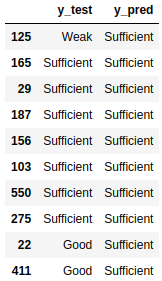

If we want to use the model to predict new observations, we have to use the following syntax .

    class_tree_gini.predict(new_obs)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/student-por.csv",
                  usecols = ["famrel", "Mjob", "Fjob",
                             "guardian", "Pstatus", "sex",
                             "internet", "health", "absences",
                             "G3"],
                  sep = ";")

df = df[["absences", "health", "sex", "internet", "Mjob", "Fjob", "guardian", "Pstatus", "famrel", "G3"]]

#make famrel ordinal
ordinal_famrel = [["Very Bad", "Bad", "Regular", "Good", "Excellent"]]

df["famrel"] = OrdinalEncoder(categories=ordinal_famrel).fit_transform(df[["famrel"]])
from sklearn.preprocessing import OrdinalEncoder

ordinal_famrel = [["Very Bad", "Bad", "Regular", "Good", "Excellent"]]

df["famrel"] = OrdinalEncoder(categories=ordinal_famrel).fit_transform(df[["famrel"]])

df["sex"].replace({"M": 0, "F": 1}, inplace=True)
df.rename(columns={"sex": "sex_fem"}, inplace=True)

guard_dummy = pd.get_dummies(df["guardian"], prefix="guardian")

df = pd.concat([df, guard_dummy], axis = 1)
df.drop("guardian", axis = 1, inplace = True)

#Transform internet in a binary number
df["internet"].replace({"no": 0, "yes": 1}, inplace = True)

#transform Pstatus in a binary number
df["Pstatus"].replace({"T": 0, "A": 1}, inplace = True)

#rename column
df.rename(columns={"Pstatus": "parents_apart"}, inplace=True)


#convert Mjob and Fjob in to dummies
dummies = pd.get_dummies(df[["Mjob", "Fjob"]],prefix=["mother","father"])
df = pd.concat([df, dummies], axis = 1)
df.drop(["Mjob","Fjob"], axis = 1, inplace = True)


    guardian_father guardian_mother guardian_other Mjob_at_home Mjob_health  \
0               0.0             1.0            0.0          1.0         0.0   
1               1.0             0.0            0.0          1.0         0.0   
2               0.0             1.0            0.0          1.0         0.0   
3               0.0             1.0            0.0          0.0         1.0   
4               1.0             0.0            0.0          0.0         0.0   
..              ...             ...            ...          ...         ...   
644             0.0             1.0            0.0          0.0         0.0   
645             0.0             1.0            0.0          0.0         0.0   
646             0.0             1.0            0.0          0.0         0.0   
647             0.0             1.0            0.0          0.0         0.0   
648             0.0             1.0            0.0          0.0         0.0   

    Mjob_other Mjob_services Mjob_teacher Fjob_at_h

<ipython-input-58-3bfdbef1cf30>:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_class["G3_qual"].mask(df_class["G3"] <= 3.4, "Poor", inplace = True)
<ipython-input-58-3bfdbef1cf30>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import numpy as np

#import decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


parent_col_trans = make_column_transformer(
    (OneHotEncoder(), ["guardian", "Mjob", "Fjob"]),
    remainder="passthrough",
    verbose_feature_names_out=False)

onehot_df = parent_col_trans.fit_transform(new_df)

df = pd.DataFrame(onehot_df, columns = parent_col_trans.get_feature_names_out())

#create X and y
X=df.drop("G3",axis=1)
y=df["G3"]

#train split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,shuffle = True,random_state = 24)

#instantiate regression tree
reg_tree_mse = DecisionTreeRegressor(criterion="squared_error",max_depth = 3,random_state = 24)

#fit regression tree
reg_tree_mse.fit(X_train,y_train)

#predict
y_pred = np.round(reg_tree_mse.predict(X_test),0)

#Plotting our Regression Tree

    from sklearn.tree import plot_tree

    import matplotlib.pyplot as plt

    plt.figure(figsize = [20.0, 8.0]) # Setting the size of displayed Tree

    plot_tree(reg_tree_mse,
        feature_names = X.columns,
        filled = True,       
        proportion = True,
        precision = 0,
        rounded = True,
        fontsize = 11)

    plt.show()

We always start by passing our instantiated tree to `plot_tree`, followed by the feature_names parameter, which is for the feature column names — we can use the `X.columns` attribute to set this parameter. For the rest of the parameters, we have the following:

* `filled` applies color to our nodes/leaves, making it easier to compare the information between them. For regression trees, it ranges from white to dark orange. For instance, if our possible values range from 10 to 14, 10 will be pure white, and 14 will be pure orange — and the intermediate values will have intermediate shades, accordingly.

* `proportion` controls how the values are represented in the nodes. If set to `True`, it will represent the samples attribute in every node with **percentages**; otherwise, it will use a **count of values** for the current node.

* `precision` sets the number of decimal places used in the values of the nodes. This applies to the values for impurity, thresholds, and the value attribute in each node. In this case, given that our target column includes only integers, we set this value to 0.

The last two parameters are for aesthetics:

* `rounded` draws the nodes with rounded corners and uses a different font, depending on your choice.

* `fontsize` is extremely helpful for controlling font sizes if our trees are big and it's hard to read the contents of the nodes.

**Some key observations:**

To avoid creating a big tree, during its creation, we limited the number of levels to 3 (not counting the root node) with the `max_depth` parameter.

The sum of the `samples` attribute values of each child node will always be equal to the samples of the parent node.

The value attribute may seem misleading, so always remember the following:

* If we use **MSE**, it will represent the **mean** of the target column.
* If we use **MAE**, it will be the **median** of the target column.

If we don't want to see the verbose array before the tree image, we can suppress it by assigning the output of the plot_tree function to a variable like _, so that:

    _ = plot_tree(...

#Plotting our Classification Tree

Now that we plotted our regression tree, what about our classification tree? Thanks to the standardized scikit-learn syntax, the process is exactly the same! We only have to consider one additional parameter for the `plot_tree` function: `class_names`, which indicates the name of the prediction class for every node/leaf.

Given that this can be a source of error when done manually (an incorrect order will cause incorrect classifications), the safest approach is to use the classes_ attribute of our instantiated tree, so that `class_names = class_tree_gini.classes_`

**Some key observations:**

`The filled` parameter now generates one color per predicted class. The color of the node/leaf is decided based on the dominant class of that specific node/leaf, and the intensity depends on how dominating it is in that node/leaf.

We set the `proportion` parameter to False, so we see counts instead of percentages.

We changed the `precision` value to 3, so now the thresholds and the gini attribute can have up to three decimal places.

The `value` attribute represents the number of observations for each specific class. It can be difficult to determine to which class each value is referring. However, since it matches the order of the classes_ attribute of our instantiated tree, we can determine the order by using the following:

    print(class_tree_gini.classes_)

    Output
    array(['Excellent', 'Good', 'Poor', 'Sufficient', 'Very Good', 'Weak'], dtype=object)


In [77]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/student-por.csv",
                  usecols = ["famrel", "Mjob", "Fjob",
                             "guardian", "Pstatus", "sex",
                             "internet", "health", "absences",
                             "G3"],
                  sep = ";")

df = df[["absences", "health", "sex", "internet", "Mjob", "Fjob", "guardian", "Pstatus", "famrel", "G3"]]


ordinal_famrel = [["Very Bad", "Bad", "Regular", "Good", "Excellent"]]

df.loc[df["health"] == "Very Bad", "health"] = 0
df.loc[df["health"] == "Bad", "health"] = 1
df.loc[df["health"] == "Regular", "health"] = 2
df.loc[df["health"] == "Good", "health"] = 3
df.loc[df["health"] == "Very Good", "health"] = 4


df[['famrel']] = OrdinalEncoder(categories = ordinal_famrel).fit_transform(df[["famrel"]])

df["sex"].replace({"M": 0, "F": 1}, inplace=True)
df.rename(columns={"sex": "sex_fem"}, inplace=True)

guard_dummy = pd.get_dummies(df["guardian"], prefix="guardian")

df = pd.concat([df, guard_dummy], axis = 1)
df.drop("guardian", axis = 1, inplace = True)

#Transform internet in a binary number
df["internet"].replace({"no": 0, "yes": 1}, inplace = True)

#transform Pstatus in a binary number
df["Pstatus"].replace({"T": 0, "A": 1}, inplace = True)

#rename column
df.rename(columns={"Pstatus": "parents_apart"}, inplace=True)


#convert Mjob and Fjob in to dummies
dummies = pd.get_dummies(df[["Mjob", "Fjob"]],prefix=["mother","father"])
df = pd.concat([df, dummies], axis = 1)
df.drop(["Mjob","Fjob"], axis = 1, inplace = True)


<ipython-input-77-e0efe5c2e0fc>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["sex"].replace({"M": 0, "F": 1}, inplace=True)
<ipython-input-77-e0efe5c2e0fc>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["sex"].replace({"M": 0, "F": 1}, inplace=True)
<ipython-input-77-e0efe5c2e0fc>:34: 

In [80]:
#copy of main df
df_class = df.copy()

#add empty column
df_class["G3_qual"] = pd.Series(dtype="object")

#creating different categories with mask()
df_class["G3_qual"].mask(df_class["G3"] <= 3.4, "Poor", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 3.4) & (df_class["G3"] <= 9.4), "Weak", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 9.4) & (df_class["G3"] <= 13.4), "Sufficient", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 13.4) & (df_class["G3"] <= 15.4), "Good", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 15.4) & (df_class["G3"] <= 17.4), "Very Good", inplace = True)

df_class["G3_qual"].mask((df_class["G3"] > 17.4), "Excellent", inplace = True)

<ipython-input-80-26d95529c5c7>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_class["G3_qual"].mask(df_class["G3"] <= 3.4, "Poor", inplace = True)
<ipython-input-80-26d95529c5c7>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

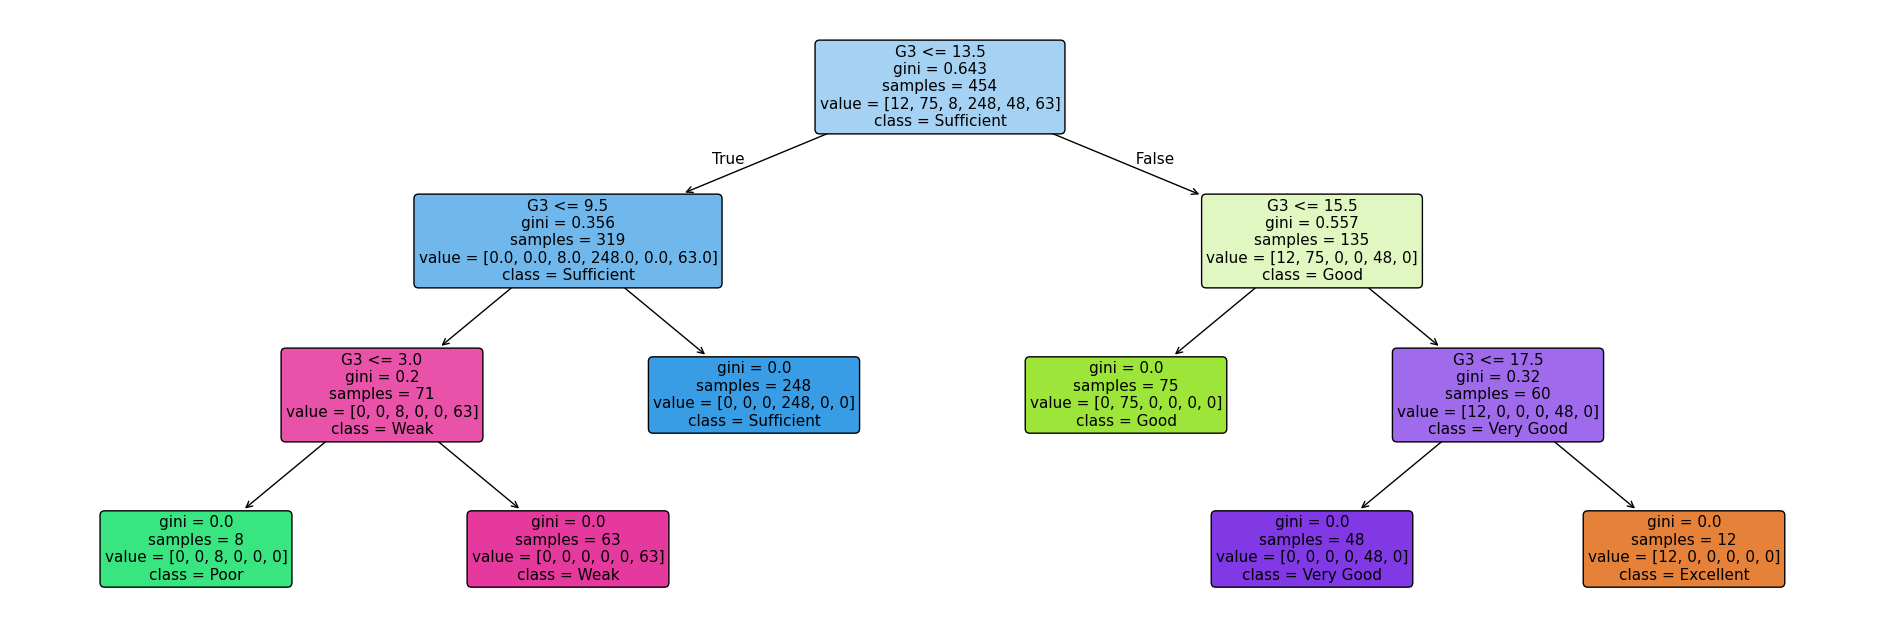

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

X = df_class.drop(["G3_qual"], axis=1)
y = df_class["G3_qual"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=24)

class_tree_gini = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=24)
class_tree_gini.fit(X_train, y_train)

plt.figure(figsize=(24,8))

#_ = supress verbose
_ = plot_tree(class_tree_gini,
    feature_names = X.columns,class_names =  class_tree_gini.classes_,
    filled = True,
    proportion = False,
    precision = 3,
    rounded = True,
    fontsize = 11)

plt.show()

#Export Tree Results

But before we finish the lesson, let's explore another useful scikit-learn tool: export_text. This function will output the rules of a decision tree in a text report:

    from sklearn.tree import export_text

    exported_tree_gini = export_text(
                              class_tree_gini,
                              feature_names = list(X.columns))

The only required parameters are our instantiated tree and `feature_names` for the column names. **Remember to always convert it to a list**; otherwise, it won't work. To view the text report, we can just print it:

    print(exported_tree_gini)

Let's look at this more closely:

* The vertical lines represent the splits. For example, the leftmost one is the split on the root node. Then we see that it divides on --- `health <= 1.50` and `--- health > 1.50.` It uses "---" to connect those splits with their corresponding thresholds.

* Also notice that the vertical line continues below the second split but doesn't connect to anything else. For this reason, we can simply ignore it beyond the second split.

*  The next set of vertical lines represents the splits for the **remaining nodes**. Note that to quickly identify the node from which they originated, the vertical lines start just before the column name of that threshold. So the split for the threshold --- `health <= 1.50` at the top, starts just before the word "health".

* In the case of this --- health <= 1.50 node, it then goes to --- internet <= 0.50 and --- internet > 0.50.

As expected, the process repeats until the path reaches the leaves, which provide us the class prediction.    

In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text


X = df.drop(["G3"], axis=1)
y = df["G3"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=24)

reg_tree_mse = DecisionTreeRegressor(criterion="squared_error", max_depth=3, random_state=24)

reg_tree_mse.fit(X_train, y_train)

exported_reg_tree = export_text(reg_tree_mse,feature_names=list(X.columns))

print(exported_reg_tree)


|--- mother_at_home <= 0.50
|   |--- sex_fem <= 0.50
|   |   |--- parents_apart <= 0.50
|   |   |   |--- value: [11.38]
|   |   |--- parents_apart >  0.50
|   |   |   |--- value: [13.50]
|   |--- sex_fem >  0.50
|   |   |--- absences <= 0.50
|   |   |   |--- value: [13.70]
|   |   |--- absences >  0.50
|   |   |   |--- value: [12.24]
|--- mother_at_home >  0.50
|   |--- guardian_father <= 0.50
|   |   |--- sex_fem <= 0.50
|   |   |   |--- value: [9.82]
|   |   |--- sex_fem >  0.50
|   |   |   |--- value: [10.79]
|   |--- guardian_father >  0.50
|   |   |--- health <= 1.50
|   |   |   |--- value: [14.43]
|   |   |--- health >  1.50
|   |   |   |--- value: [11.93]

